In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)
import spacy

import torch.utils.data as tud
from collections import Counter, defaultdict
import operator
import os, math
import numpy as np
import random
import copy
import pandas as pd

In [3]:
# set the random seeds so the experiments can be replicated exactly
seed = 30255
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
conflict_df = pd.read_csv('./data/050319_acled_all.csv')

In [5]:
conflict_df.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')

In [6]:
conflict_df['notes_char'] = conflict_df.notes.str.len()
trimmed_conflict_df = conflict_df[conflict_df['notes_char']>=100] 
trimmed_conflict_df = trimmed_conflict_df[trimmed_conflict_df['interaction']!=88]
trimmed_conflict_df = trimmed_conflict_df[trimmed_conflict_df['interaction']!=70]
trimmed_conflict_df = trimmed_conflict_df[trimmed_conflict_df['interaction']!=77]


In [7]:
len(trimmed_conflict_df)

417003

In [8]:
trimmed_conflict_df.groupby('interaction').size()

interaction
10     17676
11     10068
12     70269
13     20999
14      1595
15     14843
16     10546
17     18184
18      7243
20      6686
22      5563
23      3773
24       997
25        50
26        84
27     12893
28     11603
30      5568
33      3283
34       906
35       254
36       289
37     30299
38      3155
40       234
44      4656
45        33
46        14
47      4731
48       147
50      8122
55      6099
56       317
57      7119
58      2082
60    111422
66       177
67        34
68       420
78      5875
80      8695
dtype: int64

In [8]:
#pilot_data = trimmed_conflict_df[(trimmed_conflict_df['interaction']==13) | 
#                                 (trimmed_conflict_df['interaction']==17)]

In [9]:
def split_data(data):
    # reset index
    data_idx = data.reset_index()
    
    # subsetting in .75 train and even random split the other
    dev_test_size = round(len(data_idx)*0.25)
    tr_df = data_idx[dev_test_size:]
    dev_test_df = data_idx[:dev_test_size]
    ran_idx = np.random.choice(dev_test_size, round(dev_test_size/2), replace=False)
    dev_df = dev_test_df.iloc[ran_idx]
    test_df = dev_test_df.iloc[~ran_idx]
    
    #shuffling training so it doesn't see similar cases one after the other 
    tr_df = tr_df.sample(frac=1).reset_index(drop=True)
        
    # make them lists
    train_l = tr_df[['interaction', 'notes']].values.tolist()
    dev_l = dev_df[['interaction', 'notes']].values.tolist()
    test_l = test_df[['interaction', 'notes']].values.tolist()
    

    return train_l, dev_l, test_l

In [10]:
train_list, dev_list, test_list = split_data(trimmed_conflict_df)

In [11]:
print(len(train_list), len(dev_list), len(test_list))

312752 52126 52126


Loading data with correct formatting

In [12]:
#label_to_idx = {13: 0, 17: 1}
#idx_to_label = [13, 17]

In [12]:
label_to_idx = {10: 0, 11: 1, 12: 2, 13: 3, 14: 4, 15: 5, 
                16: 6, 17: 7, 18: 8, 20: 9, 22: 10, 23: 11, 
                24: 12, 25: 13, 26: 14, 27: 15, 28: 16, 30: 17, 
                33: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 23,
                40: 24, 44: 25, 45: 26, 46: 27, 47: 28, 48: 29,
                50: 30, 55: 31, 56: 32, 57: 33, 58: 34, 60: 35, 
                66: 36, 67: 37, 68: 38, 78: 39, 80: 40}
idx_to_label = [10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26,
                27, 28, 30, 33, 34, 35, 36, 37, 38, 40, 44, 45, 46, 47, 48,
                50, 55, 56, 57, 58, 60, 66, 67, 68, 78, 80]

In [16]:
nlp = spacy.load('en_core_web_md')

In [26]:
class InterClassifier(nn.Module):

    def __init__(self, categories_size, learn_rate = 0.01):
        super(InterClassifier, self).__init__()
        
        self.linear1 = nn.Linear(300, 128)
        self.linear2 = nn.Linear(128, 100)
        self.linear3 = nn.Linear(100, categories_size)
        
        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)

    def forward(self, inputs):
        # we ignore the embedding step since its included from spacy word2vec pre-trained model
        out = F.relu(self.linear1(inputs))
        out = F.relu(self.linear2(out))
        out = self.linear3(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    def classify(self, docs):
        '''
        This function classifies/predicts documents into their categories. 
        '''
        classif = []
        with torch.no_grad():
            for target, note in docs:
                #vectorize in embeddings using spacy pre-trained model
                embeds = (nlp(note)).vector
                note_vec = torch.tensor([embeds])

                # spacy embedding is input of model
                log_probs = self.forward(note_vec)

                # fingin the max label
                pred_idx = ((torch.topk(log_probs, 1)[1])[0]).item()
                pred = idx_to_label[pred_idx]

                # storing into output
                classif.append((target, note, pred))
        return classif            
                
                
    def evaluate_classifier_accuracy(self, data):
        '''
        This function evaluates the data with the current model. 
        data contains both documents and labels. 
        It calls classify() to make predictions, 
        and compares with the correct labels to return 
        the model accuracy on "data". 
        '''

        error_sum = 0

        # calls classify to predict label in each case
        classif_dat = self.classify(data)

        # compares target to pred and calculates error rate
        for target, note, pred in classif_dat:
            if pred == target:
                error_sum = error_sum
            else:
                error_sum += 1
        error = error_sum/len(classif_dat)
        
        return error
    
    
    def train(self, training_list, development_list, n_epochs):
        
        losses = []
        dev_err = []
        error = 1
        
        for epoch in range(n_epochs):
            i = 0
            running_loss = 0.0
            for target, note in training_list:

                # cleaning gradiatent
                self.zero_grad()
                #print(target)
                #print(note)

                # vectorizing text using spacy pre-trained model
                embeds = (nlp(note)).vector
                #print(embeds)
                note_vec = torch.tensor([embeds])
                #print(note_vec)

                # including embedding into model and predicting
                predictions = self.forward(note_vec)

                # identifying target index
                target_idx = torch.tensor([label_to_idx[target]])
                #print('predictions \n:', predictions)
                #print(target_idx)

                # calculating loss and applying gradiant descent
                loss = self.loss_function(predictions, target_idx)
                #print(list(model.parameters()))
                loss.backward()
                self.optimizer.step()

                # print statistics of loss and dev error rate. Chunck taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
                i += 1
                running_loss += loss.item()
                if i % 5000 == 0:    # print average loss every 5,000
                    print('[%5d] loss: %.3f' % (i, running_loss / 5000))
                    losses.append(running_loss)
                    running_loss = 0.0
                if i % 20000 == 0:    # check dev error every 20,000 and save best model
                    model_err = self.evaluate_classifier_accuracy(development_list)
                    print('dev error: ', model_err)
                    dev_err.append(model_err)
                    if model_err < error:
                        error = model_err
                        best_model = copy.deepcopy(self)

           
        return best_model, error, losses, dev_err
        
        
    

In [27]:
main_model = InterClassifier(41)

In [28]:
best_main, error_main, losses_main = main_model.train(train_list, dev_list, 2)

[ 5000] loss: 2.117
[10000] loss: 1.852
[15000] loss: 1.821
[20000] loss: 1.853
dev error:  0.5048
[25000] loss: 1.847
[30000] loss: 1.799
[35000] loss: 1.790
[40000] loss: 1.835
dev error:  0.443


In [37]:
test_classif_main = 

[(60,
  '05 October (on or around). APC members held demonstrations in Akure, Owo, and Ore to protest against automatic tickets for party candidates.',
  60),
 (60,
  '28 March. A peaceful protest was held by a group of internally displaced people demonstrated against the Mayor of Hargeisa in Hargeisa for not providing them land to settle. [size=no report]',
  60),
 (23,
  'An IED exploded in a military vehicle at Halku junction in the Kornish area of Quamishli city, injuring a YPG fighter who succumbed to his wounds later in the day. Two other fighters were wounded in the blast.',
  37),
 (58,
  'On Oct 5, 2 Palestinians were killed by Israeli forces, one only 14 years old, during clashes during demonstrations east of Gaza city. Across the Gaza strip a further 376 people were wounded, including 126 who had been shot.',
  37),
 (60,
  'On 20/2/2019, a group of shop owners of Jannat Bazaar in Tehran staged a protest against rental issues. [size=large]',
  60),
 (12,
  "On 24 March, the 

In [27]:
class InterClassifierLinear(nn.Module):

    def __init__(self, categories_size, learn_rate = 0.01):
        super(InterClassifierLinear, self).__init__()
        
        self.linear1 = nn.Linear(300, categories_size)

        self.loss_function = nn.NLLLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)


    def forward(self, inputs):
        # we ignore the embedding step since its included from spacy word2vec pre-trained model
        out = F.relu(self.linear1(inputs))
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    
    def classify(self, docs):
        '''
        This function classifies/predicts documents into their categories. 
        '''
        classif = []
        with torch.no_grad():
            for target, note in docs:
                #vectorize in embeddings using spacy pre-trained model
                embeds = (nlp(note)).vector
                note_vec = torch.tensor([embeds])

                # spacy embedding is input of model
                log_probs = self.forward(note_vec)

                # fingin the max label
                pred_idx = ((torch.topk(log_probs, 1)[1])[0]).item()
                pred = idx_to_label[pred_idx]

                # storing into output
                classif.append((target, note, pred))
        return classif            
                
                
    def evaluate_classifier_accuracy(self, data):
        '''
        This function evaluates the data with the current model. 
        data contains both documents and labels. 
        It calls classify() to make predictions, 
        and compares with the correct labels to return 
        the model accuracy on "data". 
        '''

        error_sum = 0

        # calls classify to predict label in each case
        classif_dat = self.classify(data)

        # compares target to pred and calculates error rate
        for target, note, pred in classif_dat:
            if pred == target:
                error_sum = error_sum
            else:
                error_sum += 1
        error = error_sum/len(classif_dat)
        
        return error
    
    
    def train(self, training_list, development_list, n_epochs):
        
        losses = []
        error = 1
        
        for epoch in range(n_epochs):
            i = 0
            running_loss = 0.0
            for target, note in training_list:

                # cleaning gradiatent
                self.zero_grad()
                #print(target)
                #print(note)

                # vectorizing text using spacy pre-trained model
                embeds = (nlp(note)).vector
                #print(embeds)
                note_vec = torch.tensor([embeds])
                #print(note_vec)

                # including embedding into model and predicting
                predictions = self.forward(note_vec)

                # identifying target index
                target_idx = torch.tensor([label_to_idx[target]])
                #print('predictions \n:', predictions)
                #print(target_idx)

                # calculating loss and applying gradiant descent
                loss = self.loss_function(predictions, target_idx)
                #print(list(model.parameters()))
                loss.backward()
                self.optimizer.step()

                # print statistics of loss and dev error rate. Chunck taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
                i += 1
                running_loss += loss.item()
                if i % 5000 == 0:    # print average loss every 5,000
                    print('[%5d] loss: %.3f' % (i, running_loss / 5000))
                    losses.append(running_loss)
                    running_loss = 0.0
                if i % 20000 == 0:    # check dev error every 20,000 and save best model
                    model_err = evaluate_classifier_accuracy(development_list)
                    print('dev error: ', model_err)
                    if model_err < error:
                        error = model_err
                        best_model = copy.deepcopy(self)

           
        return best_model, error, losses


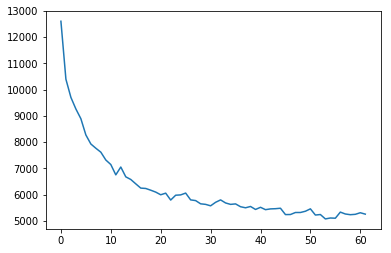

In [24]:
lossess_first = 
%matplotlib inline
pd.Series(losses).plot()

In [ ]:
Check if suffling train/test. weight newest
move to cuda
less complexity
analysis of news that getting correct or not.
learning reate
Adam optimizer
Baseline: same embedding and logistic regression (remove 2nd and 3rd)